## Libraries

In [1]:
from typing import Dict, Union
import pandas as pd
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from preprocessing import StatisticalPreprocessing, FromModelPreprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.base import BaseEstimator
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.utils import resample
import numpy as np

filterwarnings(action="ignore", category=ConvergenceWarning)
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
transformers: Dict[str, Union[FromModelPreprocessing, StatisticalPreprocessing]] = {
    "from_model": FromModelPreprocessing(),
    "statistical": StatisticalPreprocessing(),
}

In [3]:
def transformation_configuration(model: BaseEstimator, train_set: pd.DataFrame, val_set: pd.DataFrame, max_features: int = 100):
    results = {tr: [] for tr in transformers.keys()}

    for name, transformer in tqdm(transformers.items(), desc="Evaluating number of features..."):
        pbar = tqdm(range(max_features), total=max_features)
        if name == "statistical":
            transformer.fit_transform(train_set, "nbest")
        else:
            transformer.fit_transform(train_set, model)

        for i in pbar:
            pbar.set_description("Fit training...")
            train_data = transformer.change_fitted_data(i+1)
            X_train, y_train = train_data.drop(columns=["ACTIVE"]), train_data["ACTIVE"]

            pbar.set_description("Transform val...")
            X_val, y_val = val_set.drop(columns=["ACTIVE"]), val_set["ACTIVE"]
            X_val = transformer.transform(X_val)

            pbar.set_description("Fitting and predicting...")
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]

            results[name].append(roc_auc_score(y_val, y_pred))
            pbar.set_description("Score added!")
    return results

def plot_feature_auc(data: pd.DataFrame):
    data["Number of features"] = data.index + 1
    data.columns = ["Model importance", "Filtering", "Number of features"]
    data = data.melt("Number of features")
    data.columns = ["Number of features", "Approach", "ROC AUC"]


    plt.figure(figsize=(20, 5))
    sns.pointplot(data, x="Number of features", y="ROC AUC", hue="Approach", markers=["o", "^"])
    plt.xlabel("Number of features")
    plt.ylabel("AUC ROC")
    plt.tick_params("x", labelrotation=45)
    plt.tight_layout()
    plt.show()

## Data

In [4]:
full_train_set = pd.read_csv("./all_features.csv").set_index("INDEX")
train_set: pd.DataFrame
test_set: pd.DataFrame
train_set, test_set = train_test_split(full_train_set, test_size=0.3, random_state=20241209)

In [5]:
actual_train_set: pd.DataFrame
val_set: pd.DataFrame
actual_train_set, val_set = train_test_split(train_set, test_size=0.3, random_state=20241208)

## Models

### Logistic regression

In [48]:
model = LogisticRegression(class_weight="balanced")

In [ ]:
results = transformation_configuration(model, actual_train_set, val_set, 127)

pd.DataFrame(results).to_csv("./logreg_best_feature_num.csv")

Evaluating number of features...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

KeyboardInterrupt: 

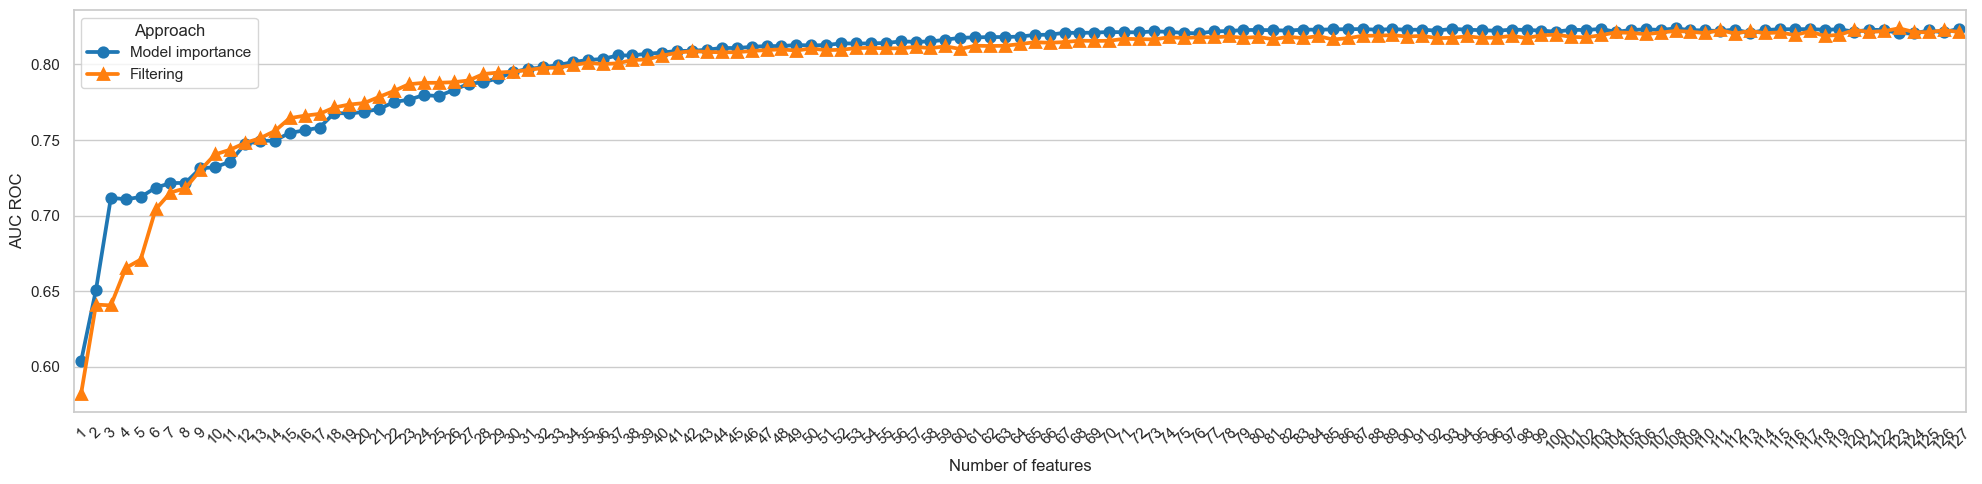

In [ ]:
data = pd.read_csv("./logreg_best_feature_num.csv", index_col=0)

plot_feature_auc(data)

In [49]:
transform = FromModelPreprocessing()

train_data = transform.fit_transform(actual_train_set, model, 70)
X_train, y_train = train_data.drop(columns=["ACTIVE"]), train_data["ACTIVE"]

X_val, y_val = transform.transform(val_set.drop(columns=["ACTIVE"])), val_set["ACTIVE"]

In [50]:
X_train.columns

Index(['n_amides', 'log_p', 'n_secamines', 'n_acceptors', 'n_carboxacids',
       'exact_weight', 'n_alihydroxyls', 'n_ethers', 'n_phenols', 'n_alkenes',
       'z_ecfp_3', 'n_priamines', 'n_bonds', 'n_donors', 'n_rotbonds',
       'n_oxos', 'n_heavyatoms', 'n_teramines', 'z_ecfp_61', 'n_arohydroxyls',
       'z_ecfp_71', 'z_ecfp_31', 'z_ecfp_41', 'z_ecfp_18', 'z_ecfp_25',
       'z_ecfp_76', 'z_ecfp_56', 'z_ecfp_46', 'z_ecfp_1', 'n_arorings',
       'z_ecfp_68', 'z_ecfp_59', 'n_sulfoanamids', 'z_ecfp_5', 'z_ecfp_58',
       'z_ecfp_0', 'z_ecfp_60', 'z_ecfp_19', 'z_ecfp_74', 'z_ecfp_66',
       'z_ecfp_96', 'z_ecfp_78', 'z_ecfp_77', 'z_ecfp_4', 'z_ecfp_29',
       'z_ecfp_27', 'z_ecfp_80', 'z_ecfp_13', 'z_ecfp_86', 'n_atoms',
       'z_ecfp_8', 'z_ecfp_24', 'n_anilines', 'z_ecfp_53', 'z_ecfp_22',
       'z_ecfp_37', 'z_ecfp_73', 'z_ecfp_7', 'z_ecfp_2', 'z_ecfp_55',
       'z_ecfp_65', 'z_ecfp_26', 'z_ecfp_47', 'z_ecfp_75', 'z_ecfp_36',
       'z_ecfp_35', 'z_ecfp_6', 'z_ecfp_40', 'z_ec

In [24]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

n_iterations = 100
auc_scores = []

for i in tqdm(range(n_iterations)):
    # Resample the test set with replacement
    indices = resample(range(len(y_val)), replace=True)
    y_test_resampled = y_val.iloc[indices]
    y_pred_resampled = y_pred[indices]
    
    # Compute AUC for the resampled set
    auc_scores.append(roc_auc_score(y_test_resampled, y_pred_resampled))

# Calculate statistics
mean_auc = np.mean(auc_scores)
confidence_interval = st.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=st.sem(auc_scores))

print(f"Mean AUC: {mean_auc}")
print(f"95% Confidence Interval: {confidence_interval}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean AUC: 0.8209440952874023
95% Confidence Interval: (0.819853399720052, 0.8220347908547526)


Mean AUC: 0.8188362203321667

95% Confidence Interval: (0.8184937570772494, 0.8191786835870841)

In [25]:
df = pd.DataFrame()
df["y_val"] = y_val
df["y_pred"] = y_pred
df.to_csv("./logreg_val_pred.csv")

### Random forests

In [35]:
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, class_weight="balanced", oob_score=roc_auc_score)

In [36]:
results = transformation_configuration(model, actual_train_set, val_set, 127)

pd.DataFrame(results).to_csv("./randfor_best_feature_num.csv")

Evaluating number of features...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

c:\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=101889 is greater than n_features=127. All the features will be returned.
  warnings.warn(


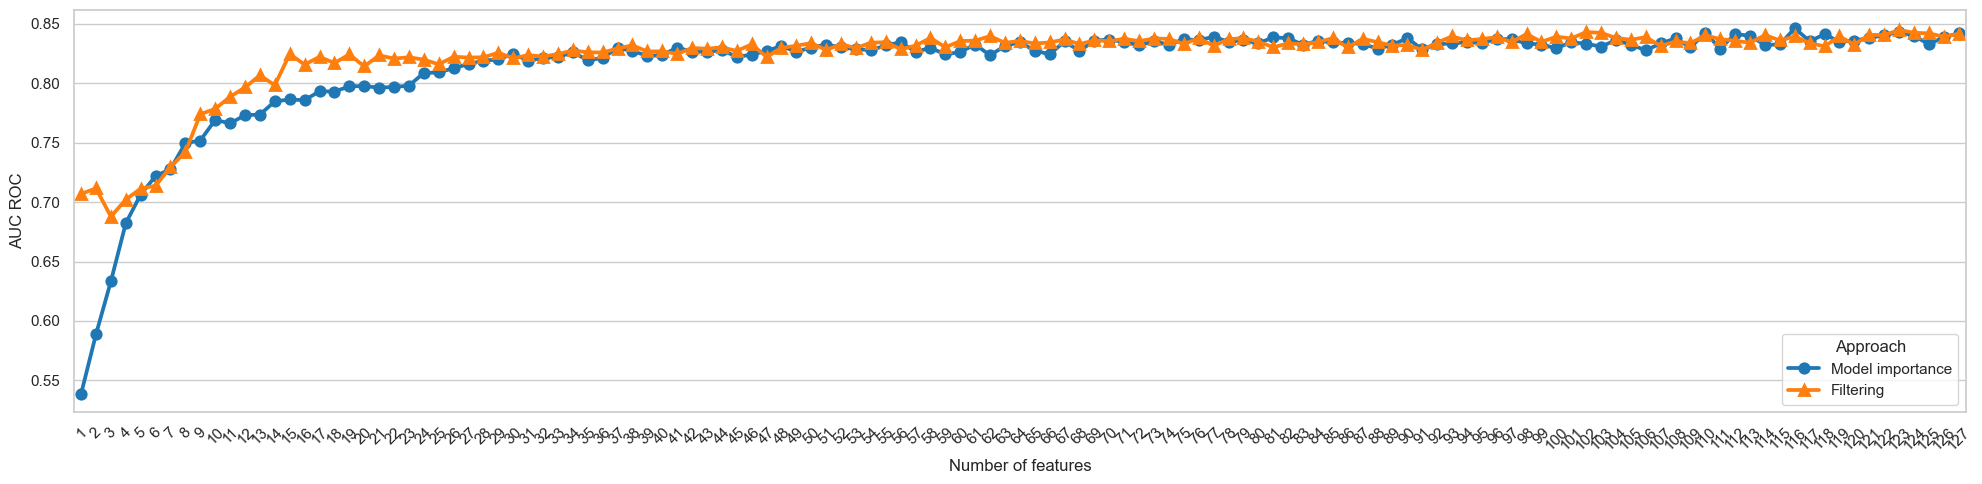

In [39]:
data = pd.read_csv("./randfor_best_feature_num.csv", index_col=0)

plot_feature_auc(data)

In [10]:
transform = StatisticalPreprocessing()

train_data = transform.fit_transform(actual_train_set, "nbest", 62)
X_train, y_train = train_data.drop(columns=["ACTIVE"]), train_data["ACTIVE"]

X_val, y_val = transform.transform(val_set.drop(columns=["ACTIVE"])), val_set["ACTIVE"]

c:\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=101889 is greater than n_features=127. All the features will be returned.
  warnings.warn(


In [85]:
X_train.columns

Index(['TPSA', 'n_secamines', 'exact_weight', 'n_arorings', 'n_donors',
       'n_amides', 'n_ethers', 'z_ecfp_61', 'log_p', 'n_rotbonds',
       'n_anilines', 'n_teramines', 'z_ecfp_3', 'n_acceptors',
       'n_sulfoanamids', 'n_oxos', 'z_ecfp_1', 'n_heavyatoms', 'z_ecfp_56',
       'n_atoms', 'n_chloros', 'z_ecfp_25', 'n_phenols', 'n_bonds',
       'z_ecfp_66', 'z_ecfp_18', 'z_ecfp_85', 'z_ecfp_40', 'n_alkenes',
       'z_ecfp_46', 'z_ecfp_7', 'z_ecfp_64', 'z_ecfp_71', 'n_halogens',
       'z_ecfp_59', 'z_ecfp_60', 'z_ecfp_93', 'z_ecfp_48', 'z_ecfp_55',
       'z_ecfp_99', 'z_ecfp_8', 'z_ecfp_0', 'z_ecfp_74', 'z_ecfp_52',
       'z_ecfp_29', 'z_ecfp_82', 'z_ecfp_67', 'z_ecfp_65', 'z_ecfp_44',
       'z_ecfp_6', 'z_ecfp_26', 'n_priamines', 'z_ecfp_37', 'z_ecfp_53',
       'z_ecfp_68', 'z_ecfp_22', 'n_nitriles', 'z_ecfp_4', 'z_ecfp_79',
       'z_ecfp_58', 'z_ecfp_31', 'z_ecfp_13'],
      dtype='object')

In [86]:
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, class_weight="balanced", oob_score=roc_auc_score)

X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])
cv_indexes = np.array([-1] * len(X_train) + [0] * len(X_val), dtype=np.int32)
cv = PredefinedSplit(cv_indexes)

n_estimators_range = np.logspace(1.3, 2.7, 13, dtype=np.int32)
max_depth_range = np.logspace(0.2, 1.7, 13, dtype=np.int32)
param_grid = dict(n_estimators=n_estimators_range, max_depth=max_depth_range)

scorer = make_scorer(roc_auc_score, response_method="predict_proba")

grid = GridSearchCV(
    model, param_grid=param_grid, cv=cv, verbose=3, scoring=scorer
)
grid.fit(X_cv, y_cv)

print(
    f"The best parameters are {grid.best_params_} with a score of {grid.best_score_:0.3f}"
)

Fitting 1 folds for each of 169 candidates, totalling 169 fits


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=1, n_estimators=19;, score=0.713 total time=   0.9s
[CV 1/1] END ......max_depth=1, n_estimators=26;, score=0.710 total time=   1.2s
[CV 1/1] END ......max_depth=1, n_estimators=34;, score=0.730 total time=   1.3s
[CV 1/1] END ......max_depth=1, n_estimators=44;, score=0.735 total time=   1.7s
[CV 1/1] END ......max_depth=1, n_estimators=58;, score=0.732 total time=   2.2s
[CV 1/1] END ......max_depth=1, n_estimators=76;, score=0.744 total time=   2.9s
[CV 1/1] END .....max_depth=1, n_estimators=100;, score=0.734 total time=   3.6s
[CV 1/1] END .....max_depth=1, n_estimators=130;, score=0.725 total time=   4.6s
[CV 1/1] END .....max_depth=1, n_estimators=171;, score=0.749 total time=   6.2s
[CV 1/1] END .....max_depth=1, n_estimators=223;, score=0.740 total time=   7.7s
[CV 1/1] END .....max_depth=1, n_estimators=292;, score=0.744 total time=  10.4s
[CV 1/1] END .....max_depth=1, n_estimators=383;, score=0.744 total time=  13.7s
[CV 1/1] END .....max_depth=

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=2, n_estimators=19;, score=0.730 total time=   1.1s
[CV 1/1] END ......max_depth=2, n_estimators=26;, score=0.750 total time=   1.8s
[CV 1/1] END ......max_depth=2, n_estimators=34;, score=0.749 total time=   2.0s
[CV 1/1] END ......max_depth=2, n_estimators=44;, score=0.760 total time=   2.5s
[CV 1/1] END ......max_depth=2, n_estimators=58;, score=0.757 total time=   3.2s
[CV 1/1] END ......max_depth=2, n_estimators=76;, score=0.761 total time=   4.0s
[CV 1/1] END .....max_depth=2, n_estimators=100;, score=0.759 total time=   5.1s
[CV 1/1] END .....max_depth=2, n_estimators=130;, score=0.762 total time=   6.8s
[CV 1/1] END .....max_depth=2, n_estimators=171;, score=0.763 total time=   8.8s
[CV 1/1] END .....max_depth=2, n_estimators=223;, score=0.761 total time=  11.6s
[CV 1/1] END .....max_depth=2, n_estimators=292;, score=0.760 total time=  14.9s
[CV 1/1] END .....max_depth=2, n_estimators=383;, score=0.763 total time=  17.7s
[CV 1/1] END .....max_depth=

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=2, n_estimators=19;, score=0.742 total time=   1.2s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=2, n_estimators=26;, score=0.747 total time=   1.6s
[CV 1/1] END ......max_depth=2, n_estimators=34;, score=0.743 total time=   2.4s
[CV 1/1] END ......max_depth=2, n_estimators=44;, score=0.757 total time=   2.4s
[CV 1/1] END ......max_depth=2, n_estimators=58;, score=0.749 total time=   3.0s
[CV 1/1] END ......max_depth=2, n_estimators=76;, score=0.763 total time=   3.9s
[CV 1/1] END .....max_depth=2, n_estimators=100;, score=0.759 total time=   5.1s
[CV 1/1] END .....max_depth=2, n_estimators=130;, score=0.758 total time=   6.8s
[CV 1/1] END .....max_depth=2, n_estimators=171;, score=0.760 total time=   8.9s
[CV 1/1] END .....max_depth=2, n_estimators=223;, score=0.764 total time=  11.2s
[CV 1/1] END .....max_depth=2, n_estimators=292;, score=0.762 total time=  14.8s
[CV 1/1] END .....max_depth=2, n_estimators=383;, score=0.761 total time=  19.4s
[CV 1/1] END .....max_depth=2, n_estimators=501;, score=0.762 total time=  24.7s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=3, n_estimators=19;, score=0.762 total time=   1.4s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=3, n_estimators=26;, score=0.766 total time=   1.9s
[CV 1/1] END ......max_depth=3, n_estimators=34;, score=0.772 total time=   2.6s
[CV 1/1] END ......max_depth=3, n_estimators=44;, score=0.771 total time=   2.9s
[CV 1/1] END ......max_depth=3, n_estimators=58;, score=0.774 total time=   3.7s
[CV 1/1] END ......max_depth=3, n_estimators=76;, score=0.771 total time=   5.1s
[CV 1/1] END .....max_depth=3, n_estimators=100;, score=0.771 total time=   6.4s
[CV 1/1] END .....max_depth=3, n_estimators=130;, score=0.776 total time=   8.5s
[CV 1/1] END .....max_depth=3, n_estimators=171;, score=0.775 total time=  10.5s
[CV 1/1] END .....max_depth=3, n_estimators=223;, score=0.775 total time=  13.8s
[CV 1/1] END .....max_depth=3, n_estimators=292;, score=0.776 total time=  18.0s
[CV 1/1] END .....max_depth=3, n_estimators=383;, score=0.777 total time=  24.1s
[CV 1/1] END .....max_depth=3, n_estimators=501;, score=0.777 total time=  30.9s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=5, n_estimators=19;, score=0.791 total time=   2.0s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=5, n_estimators=26;, score=0.788 total time=   2.9s
[CV 1/1] END ......max_depth=5, n_estimators=34;, score=0.791 total time=   3.5s
[CV 1/1] END ......max_depth=5, n_estimators=44;, score=0.792 total time=   4.4s
[CV 1/1] END ......max_depth=5, n_estimators=58;, score=0.792 total time=   5.9s
[CV 1/1] END ......max_depth=5, n_estimators=76;, score=0.796 total time=   7.6s
[CV 1/1] END .....max_depth=5, n_estimators=100;, score=0.798 total time=   9.3s
[CV 1/1] END .....max_depth=5, n_estimators=130;, score=0.793 total time=  12.9s
[CV 1/1] END .....max_depth=5, n_estimators=171;, score=0.797 total time=  16.4s
[CV 1/1] END .....max_depth=5, n_estimators=223;, score=0.797 total time=  21.3s
[CV 1/1] END .....max_depth=5, n_estimators=292;, score=0.797 total time=  28.1s
[CV 1/1] END .....max_depth=5, n_estimators=383;, score=0.797 total time=  37.5s
[CV 1/1] END .....max_depth=5, n_estimators=501;, score=0.797 total time=  47.7s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=6, n_estimators=19;, score=0.794 total time=   2.6s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=6, n_estimators=26;, score=0.796 total time=   3.5s
[CV 1/1] END ......max_depth=6, n_estimators=34;, score=0.799 total time=   4.1s
[CV 1/1] END ......max_depth=6, n_estimators=44;, score=0.796 total time=   5.4s
[CV 1/1] END ......max_depth=6, n_estimators=58;, score=0.801 total time=   6.8s
[CV 1/1] END ......max_depth=6, n_estimators=76;, score=0.799 total time=   8.7s
[CV 1/1] END .....max_depth=6, n_estimators=100;, score=0.803 total time=  12.1s
[CV 1/1] END .....max_depth=6, n_estimators=130;, score=0.805 total time=  14.7s
[CV 1/1] END .....max_depth=6, n_estimators=171;, score=0.803 total time=  19.0s
[CV 1/1] END .....max_depth=6, n_estimators=223;, score=0.805 total time=  24.9s
[CV 1/1] END .....max_depth=6, n_estimators=292;, score=0.807 total time=  32.3s
[CV 1/1] END .....max_depth=6, n_estimators=383;, score=0.808 total time=  43.1s
[CV 1/1] END .....max_depth=6, n_estimators=501;, score=0.806 total time=  57.1s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END ......max_depth=8, n_estimators=19;, score=0.805 total time=   3.2s
[CV 1/1] END ......max_depth=8, n_estimators=26;, score=0.805 total time=   4.8s
[CV 1/1] END ......max_depth=8, n_estimators=34;, score=0.811 total time=   4.9s
[CV 1/1] END ......max_depth=8, n_estimators=44;, score=0.811 total time=   6.3s
[CV 1/1] END ......max_depth=8, n_estimators=58;, score=0.815 total time=   8.7s
[CV 1/1] END ......max_depth=8, n_estimators=76;, score=0.814 total time=  10.9s
[CV 1/1] END .....max_depth=8, n_estimators=100;, score=0.819 total time=  14.5s
[CV 1/1] END .....max_depth=8, n_estimators=130;, score=0.815 total time=  18.0s
[CV 1/1] END .....max_depth=8, n_estimators=171;, score=0.817 total time=  24.9s
[CV 1/1] END .....max_depth=8, n_estimators=223;, score=0.816 total time=  30.6s
[CV 1/1] END .....max_depth=8, n_estimators=292;, score=0.819 total time=  39.9s
[CV 1/1] END .....max_depth=8, n_estimators=383;, score=0.817 total time=  51.5s
[CV 1/1] END .....max_depth=

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=11, n_estimators=19;, score=0.808 total time=   3.8s
[CV 1/1] END .....max_depth=11, n_estimators=26;, score=0.803 total time=   5.4s
[CV 1/1] END .....max_depth=11, n_estimators=34;, score=0.816 total time=   6.4s
[CV 1/1] END .....max_depth=11, n_estimators=44;, score=0.819 total time=   7.9s
[CV 1/1] END .....max_depth=11, n_estimators=58;, score=0.817 total time=  10.4s
[CV 1/1] END .....max_depth=11, n_estimators=76;, score=0.822 total time=  14.0s
[CV 1/1] END ....max_depth=11, n_estimators=100;, score=0.821 total time=  18.0s
[CV 1/1] END ....max_depth=11, n_estimators=130;, score=0.825 total time=  23.0s
[CV 1/1] END ....max_depth=11, n_estimators=171;, score=0.823 total time=  30.7s
[CV 1/1] END ....max_depth=11, n_estimators=223;, score=0.824 total time=  38.5s
[CV 1/1] END ....max_depth=11, n_estimators=292;, score=0.824 total time=  50.1s
[CV 1/1] END ....max_depth=11, n_estimators=383;, score=0.825 total time= 1.1min
[CV 1/1] END ....max_depth=1

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=15, n_estimators=19;, score=0.795 total time=   4.4s
[CV 1/1] END .....max_depth=15, n_estimators=26;, score=0.815 total time=   6.2s
[CV 1/1] END .....max_depth=15, n_estimators=34;, score=0.814 total time=   7.9s
[CV 1/1] END .....max_depth=15, n_estimators=44;, score=0.816 total time=   9.1s
[CV 1/1] END .....max_depth=15, n_estimators=58;, score=0.821 total time=  12.0s
[CV 1/1] END .....max_depth=15, n_estimators=76;, score=0.827 total time=  15.6s
[CV 1/1] END ....max_depth=15, n_estimators=100;, score=0.827 total time=  19.5s
[CV 1/1] END ....max_depth=15, n_estimators=130;, score=0.827 total time=  25.6s
[CV 1/1] END ....max_depth=15, n_estimators=171;, score=0.828 total time=  33.6s
[CV 1/1] END ....max_depth=15, n_estimators=223;, score=0.828 total time=  44.8s
[CV 1/1] END ....max_depth=15, n_estimators=292;, score=0.831 total time= 1.0min
[CV 1/1] END ....max_depth=15, n_estimators=383;, score=0.830 total time= 1.4min
[CV 1/1] END ....max_depth=1

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=21, n_estimators=19;, score=0.796 total time=   5.0s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=21, n_estimators=26;, score=0.803 total time=   6.8s
[CV 1/1] END .....max_depth=21, n_estimators=34;, score=0.814 total time=   8.6s
[CV 1/1] END .....max_depth=21, n_estimators=44;, score=0.813 total time=  10.6s
[CV 1/1] END .....max_depth=21, n_estimators=58;, score=0.830 total time=  12.9s
[CV 1/1] END .....max_depth=21, n_estimators=76;, score=0.829 total time=  18.3s
[CV 1/1] END ....max_depth=21, n_estimators=100;, score=0.837 total time=  22.5s
[CV 1/1] END ....max_depth=21, n_estimators=130;, score=0.840 total time=  28.8s
[CV 1/1] END ....max_depth=21, n_estimators=171;, score=0.843 total time=  37.0s
[CV 1/1] END ....max_depth=21, n_estimators=223;, score=0.838 total time=  47.4s
[CV 1/1] END ....max_depth=21, n_estimators=292;, score=0.844 total time= 1.1min
[CV 1/1] END ....max_depth=21, n_estimators=383;, score=0.846 total time= 1.4min
[CV 1/1] END ....max_depth=21, n_estimators=501;, score=0.845 total time= 1.8min


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=28, n_estimators=19;, score=0.777 total time=   5.0s
[CV 1/1] END .....max_depth=28, n_estimators=26;, score=0.792 total time=   6.9s
[CV 1/1] END .....max_depth=28, n_estimators=34;, score=0.809 total time=   7.5s
[CV 1/1] END .....max_depth=28, n_estimators=44;, score=0.809 total time=  10.0s
[CV 1/1] END .....max_depth=28, n_estimators=58;, score=0.824 total time=  12.9s
[CV 1/1] END .....max_depth=28, n_estimators=76;, score=0.829 total time=  17.1s
[CV 1/1] END ....max_depth=28, n_estimators=100;, score=0.839 total time=  22.6s
[CV 1/1] END ....max_depth=28, n_estimators=130;, score=0.842 total time=  28.1s
[CV 1/1] END ....max_depth=28, n_estimators=171;, score=0.850 total time=  36.5s
[CV 1/1] END ....max_depth=28, n_estimators=223;, score=0.849 total time=  47.9s
[CV 1/1] END ....max_depth=28, n_estimators=292;, score=0.853 total time=  59.2s
[CV 1/1] END ....max_depth=28, n_estimators=383;, score=0.852 total time= 1.3min
[CV 1/1] END ....max_depth=2

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=37, n_estimators=19;, score=0.769 total time=   4.3s
[CV 1/1] END .....max_depth=37, n_estimators=26;, score=0.787 total time=   6.3s
[CV 1/1] END .....max_depth=37, n_estimators=34;, score=0.798 total time=   7.1s
[CV 1/1] END .....max_depth=37, n_estimators=44;, score=0.804 total time=   9.6s
[CV 1/1] END .....max_depth=37, n_estimators=58;, score=0.814 total time=  12.2s
[CV 1/1] END .....max_depth=37, n_estimators=76;, score=0.830 total time=  15.9s
[CV 1/1] END ....max_depth=37, n_estimators=100;, score=0.841 total time=  20.4s
[CV 1/1] END ....max_depth=37, n_estimators=130;, score=0.837 total time=  26.7s
[CV 1/1] END ....max_depth=37, n_estimators=171;, score=0.842 total time=  35.3s
[CV 1/1] END ....max_depth=37, n_estimators=223;, score=0.848 total time=  44.7s
[CV 1/1] END ....max_depth=37, n_estimators=292;, score=0.851 total time=  59.8s
[CV 1/1] END ....max_depth=37, n_estimators=383;, score=0.853 total time= 1.3min
[CV 1/1] END ....max_depth=3

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=50, n_estimators=19;, score=0.762 total time=   4.4s


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/1] END .....max_depth=50, n_estimators=26;, score=0.787 total time=   6.2s
[CV 1/1] END .....max_depth=50, n_estimators=34;, score=0.798 total time=   7.4s
[CV 1/1] END .....max_depth=50, n_estimators=44;, score=0.804 total time=   9.4s
[CV 1/1] END .....max_depth=50, n_estimators=58;, score=0.818 total time=  12.0s
[CV 1/1] END .....max_depth=50, n_estimators=76;, score=0.827 total time=  16.2s
[CV 1/1] END ....max_depth=50, n_estimators=100;, score=0.825 total time=  21.4s
[CV 1/1] END ....max_depth=50, n_estimators=130;, score=0.839 total time=  27.6s
[CV 1/1] END ....max_depth=50, n_estimators=171;, score=0.842 total time=  34.7s
[CV 1/1] END ....max_depth=50, n_estimators=223;, score=0.849 total time=  45.1s
[CV 1/1] END ....max_depth=50, n_estimators=292;, score=0.854 total time=  58.7s
[CV 1/1] END ....max_depth=50, n_estimators=383;, score=0.857 total time= 1.3min
[CV 1/1] END ....max_depth=50, n_estimators=501;, score=0.857 total time= 1.8min
The best parameters are {'ma

Best: 'max_depth': 37, 'n_estimators': 501
Suggested: max_depth = 28, estimators = 292

In [12]:
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, class_weight="balanced", oob_score=roc_auc_score, max_depth=28, n_estimators=292)
n_iterations = 100
auc_scores = []

for i in tqdm(range(n_iterations)):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Compute AUC for the resampled set
    auc_scores.append(roc_auc_score(y_val, y_pred))

# Calculate statistics
mean_auc = np.mean(auc_scores)
confidence_interval = st.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=st.sem(auc_scores))

print(f"Mean AUC: {mean_auc}")
print(f"95% Confidence Interval: {confidence_interval}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean AUC: 0.8548094396604536
95% Confidence Interval: (0.854501503420314, 0.8551173759005933)


In [15]:
y_pred

array([0.0261106 , 0.03934453, 0.01193299, ..., 0.01369863, 0.0239726 ,
       0.04744149])

In [17]:
df = pd.DataFrame()
df["y_val"] = y_val
df["y_pred"] = y_pred
df.to_csv("./randfor_val_pred.csv")

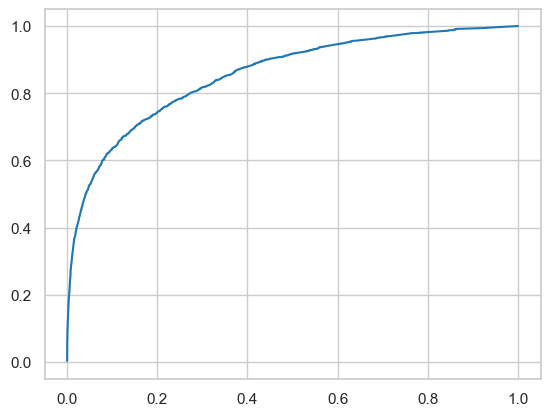

In [ ]:
fpr, tpr, _ = roc_curve(y_val,  y_pred)
sns.lineplot(x=fpr, y=tpr)
plt.show()

Mean AUC: 0.8548094396604536

95% Confidence Interval: (0.854501503420314, 0.8551173759005933)

## Estimating model performance

In [26]:
transform = StatisticalPreprocessing()

train_data = transform.fit_transform(train_set, "nbest", 62)
X_train, y_train = train_data.drop(columns=["ACTIVE"]), train_data["ACTIVE"]

X_test, y_test = transform.transform(test_set.drop(columns=["ACTIVE"])), test_set["ACTIVE"]

c:\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=145306 is greater than n_features=127. All the features will be returned.
  warnings.warn(


In [27]:
X_train.columns

Index(['TPSA', 'n_secamines', 'n_arorings', 'exact_weight', 'n_donors',
       'n_amides', 'n_anilines', 'n_ethers', 'n_rotbonds', 'log_p',
       'z_ecfp_61', 'n_teramines', 'n_acceptors', 'n_heavyatoms',
       'n_sulfoanamids', 'z_ecfp_3', 'n_alkenes', 'n_atoms', 'n_halogens',
       'z_ecfp_26', 'n_oxos', 'z_ecfp_1', 'z_ecfp_46', 'n_bonds', 'z_ecfp_60',
       'z_ecfp_73', 'z_ecfp_25', 'n_carboxacids', 'z_ecfp_56', 'z_ecfp_68',
       'z_ecfp_72', 'z_ecfp_29', 'n_nitriles', 'z_ecfp_57', 'z_ecfp_0',
       'z_ecfp_44', 'z_ecfp_79', 'z_ecfp_18', 'z_ecfp_80', 'z_ecfp_6',
       'z_ecfp_4', 'n_chloros', 'z_ecfp_39', 'z_ecfp_66', 'z_ecfp_65',
       'z_ecfp_84', 'z_ecfp_55', 'z_ecfp_10', 'z_ecfp_11', 'z_ecfp_85',
       'z_ecfp_87', 'z_ecfp_7', 'z_ecfp_88', 'z_ecfp_31', 'n_alihydroxyls',
       'n_phenols', 'z_ecfp_33', 'z_ecfp_98', 'z_ecfp_99', 'z_ecfp_35',
       'z_ecfp_74', 'z_ecfp_41'],
      dtype='object')

In [28]:
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, class_weight="balanced", oob_score=roc_auc_score, max_depth=28, n_estimators=292)
n_iterations = 100
auc_scores = []

for i in tqdm(range(n_iterations)):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    
    # Compute AUC for the resampled set
    auc_scores.append(roc_auc_score(y_test, y_pred))

# Calculate statistics
mean_auc = np.mean(auc_scores)
confidence_interval = st.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=st.sem(auc_scores))

print(f"Mean AUC: {mean_auc}")
print(f"95% Confidence Interval: {confidence_interval}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean AUC: 0.8667878093964951
95% Confidence Interval: (0.8665191942514195, 0.8670564245415707)


In [31]:
df = pd.DataFrame()
df["y_val"] = y_test
df["y_pred"] = y_pred
df.to_csv("./randfor_test_pred.csv")

## Final inference

In [39]:
from importlib import reload
import preprocessing as pre

reload(pre)

test_set = pd.read_csv("../test_smiles.csv")

transform = pre.StatisticalPreprocessing()

train_data = transform.fit_transform(full_train_set, "nbest", 62)
X_train, y_train = train_data.drop(columns=["ACTIVE"]), train_data["ACTIVE"]

X_test = transform.transform(test_set, expand=True)

c:\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=207130 is greater than n_features=127. All the features will be returned.
  warnings.warn(


Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

[16:41:01] WARNING: not removing hydrogen atom without neighbors


Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69646 [00:00<?, ?it/s]

In [41]:
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, class_weight="balanced", oob_score=roc_auc_score, max_depth=28, n_estimators=292)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

out = [0.8667878093964951] + list(y_pred.tolist())

In [42]:
output_path = "../5.txt"
with open(output_path, "w", encoding="utf-8") as file:
    for v in out:
        file.write(f"{v}\n")

In [43]:
predictions_df = pd.read_csv(output_path, header=None)
assert predictions_df.shape == (69646+1, 1)
assert np.all((predictions_df.values >= 0) & (predictions_df.values <= 1))